<a href="https://colab.research.google.com/github/omendez930/Bank-Fraud-Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Fraud Detection**

# Business Understanding

Objective:

The primary goal of analyzing this dataset is to detect fraudulent bank transactions. Fraudulent activities can cause significant financial losses for banks and customers. By leveraging machine learning and data analysis, we aim to build a model that can distinguish between legitimate and fraudulent transactions in real time.



*   A high-performing fraud detection model that minimizes false positives (legitimate transactions incorrectly flagged as fraud) and false negatives (fraudulent transactions that go undetected).
*   The model should generalize well to unseen data to be deployable in a real-world setting.
*   Business value: reducing financial losses due to fraud and enhancing customer trust in the bank’s security systems.

# Data Understanding

Key Features to Examine:

The dataset contains 200k rows of transactional data labeled as fraudulent or non-fraudulent. Each row represents a transaction with various features describing its characteristics.



1.   Gender: The gender of the consumer (e.G., Male, Female, Other). Four.
2.   Age: The age of the consumer at the time of the transaction.
3.   State: The nation in which the patron resides.
4.   Bank_Branch: The specific financial institution branch wherein the consumer holds their account.
5.   Account_Type: The kind of account held with the aid of the customer (e.G., Savings, Checking). Nine.
6.   Transaction_ID: A particular identifier for each transaction.
7.   Transaction_Date: The date on which the transaction passed off. Eleven.
8.   Transaction_Time: The specific time the transaction became initiated.
9.   Transaction_Amount: The financial value of the transaction.
10.  Merchant_ID: A particular identifier for the merchant worried within the transaction.
11.  Transaction_Type: The nature of the transaction (e.G., Withdrawal, Deposit, Transfer).
12.   Merchant_Category: The class of the merchant (e.G., Retail, Online, Travel).
13.   Account_Balance: The balance of the customer's account after the transaction.
14.   Transaction_Device: The tool utilized by the consumer to perform the transaction (e.G., Mobile, Desktop).
15.   Transaction_Location: The geographical vicinity (e.G., latitude, longitude) of the transaction.
16.   Device_Type: The kind of device used for the transaction (e.G., Smartphone, Laptop).
17.   Is_Fraud: A binary indicator (1 or zero) indicating whether or not the transaction is fraudulent or now not.
18.   Transaction_Currency: The currency used for the transaction (e.G., USD, EUR).
19.   Transaction_Description: A brief description of the transaction (e.G., buy, switch).







In [ ]:
!kaggle datasets download -d orangelmendez/bank-fraud

In [ ]:
!unzip bank-fraud.zip -d data

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import classification_report, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
bank_df = pd.read_csv('./data/new_bank_fraud_detection.csv', encoding='utf-8', index_col=0)
bank_df.head()

In [ ]:
bank_df.describe()

In [ ]:
bank_df.columns

In [ ]:
bank_df.isnull().sum()

In [ ]:
bank_df.dtypes

Let's combine the "Transaction_Date" and "Transaction_Time" columns together, and convert it into a datetime dtype.

In [ ]:
bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])
bank_df[['Transaction_Date','Transaction_Time']]

bank_df.dtypes

In [ ]:
#convert the Transaction Date to Date
bank_df['Transaction_Date'] = pd.to_datetime(bank_df['Transaction_Date'])
bank_df = bank_df.drop(columns=['Transaction_Date','Transaction_Time'], axis=1)
bank_df.dtypes

## **Visualizations**

We'll start with some descriptive statistics. We'll visualize the distribution of fraudulent transactions that occur within the data. This shows the class distribution and helps you check if the data is imbalanced.

Next, lets check the distribution of Transaction Amounts. This helps visualize the distribution of transaction amounts and understand any skewness.

## **Fraud Distribution**

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='Is_Fraud', data=bank_df, palette='Set2')
plt.title('Distribution of Fraudulent vs Non-Fraudulent transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Thousands)')
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.show()


## **Distribution of Transaction Amounts**

This scatterplot can help assess if there's a relationship between the transaction amount and whether the transaction is fraudulent or not.

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(bank_df['Transaction_Amount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')
plt.title('Transaction Amount vs Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

## **Fraud by Transaction Type**

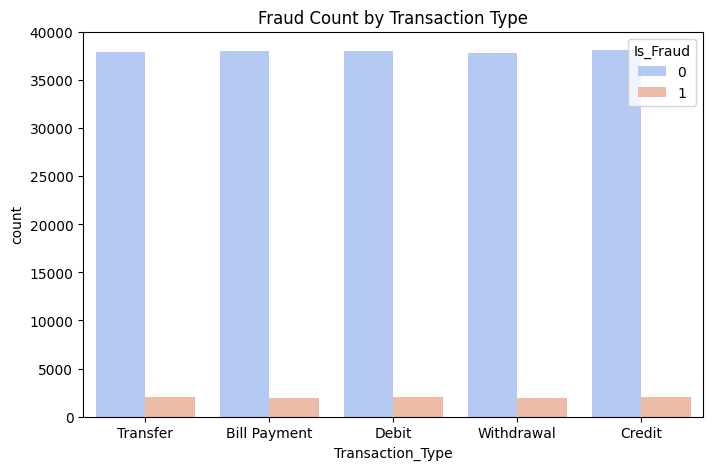

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(data=bank_df, x='Transaction_Type', hue='Is_Fraud', palette='coolwarm')
plt.title("Fraud Count by Transaction Type")
plt.show()

## **Time-Based Analysis**

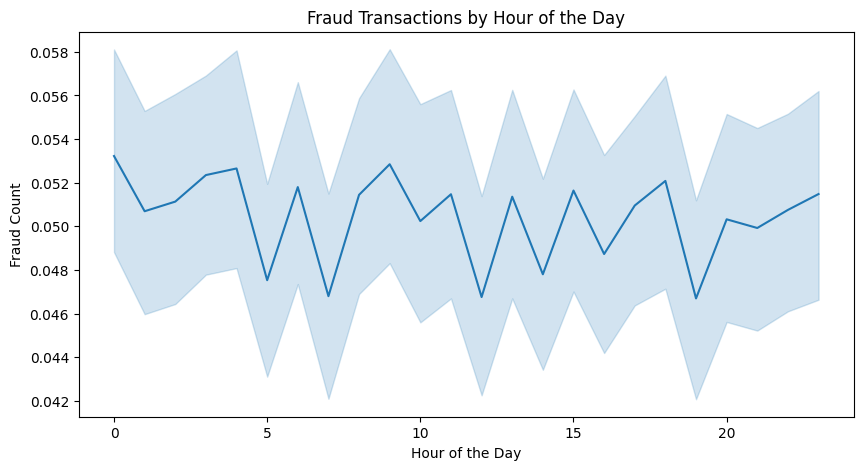

In [27]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df.set_index('Transaction_DateTime', inplace=True)
    bank_df['hour'] = bank_df.index.hour

    plt.figure(figsize=(10,5))
    sns.lineplot(x=bank_df['hour'], y=bank_df['Is_Fraud'])
    plt.title("Fraud Transactions by Hour of the Day")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Fraud Count")
    plt.show()


## **Convert Datetime Features**

In [ ]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df['Transaction_Hour'] = bank_df['Transaction_DateTime'].dt.hour
    bank_df['Transaction_Day'] = bank_df['Transaction_DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
    df.drop(columns=['Transaction_date', 'Transaction_time'], inplace=True)  # Drop original timestamp


In [ ]:
categorical_columns = bank_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)

In [ ]:
# Define feature matrix (X) and target variable (y)

X = bank_df.drop(columns=['Is_Fraud'])
y = bank_df['Is_Fraud']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

## **Train a Classification Model**

## Baseline Model

I'll start by creating a baseline LogisticRegression model. I'll start by Standardizing the categorical columns and Numberical columns.

Once standaridized, I will create a pipeline that creates a baseline model.

In [ ]:
print(y_train.value_counts(normalize=True))

### **Model the pipeline**

In [32]:
# Identify numerical & categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),  # Categorical encoding
        ('num', StandardScaler(), numerical_columns)  # Scale numerical columns
    ],
    remainder='passthrough'  # Keep all columns not explicitly transformed
)

logreg_pipeline = Pipeline([
    ('preprocesson', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=33))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
# pipeline =

# # Fit and transform training data
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(classification_report(y_test, y_pred, zero_division=1))

[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       1.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.97      0.50      0.49     40000
weighted avg       0.95      0.95      0.92     40000



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


As shown earlier the dataset is imbalanced between counts that were considered to be fraudulent and counts that were not. Let's use XGBoost to address imblance. It's one of the best classifiers for this type of issue and works well for fraud detection

In [ ]:
# Create XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=33))
])

# Define hyperparameters for tuning
xgb_params = {
    'classifier__n_estimators': [100,300],
    'classifier__max_depth': [3,6],
    'classifier__learning_rate': [0.01, 0.1]
}

#Grid Search for best parameters
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best Model Performance
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_xgb, zero_division=1))

In [ ]:
# Create Random Forest pipeline

rf_pipeline =  ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote',  SMOTE(sampling_strategy='auto', random_state=33)),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=33))
])

rf_params = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,5]
}

# Grisd Search for best parameters
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Evaluate best model
y_pred_rf = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=1))

In [ ]:
best_rf_model = rf_grid.best_estimator_.named_steps['classifier']
feature_importances = best_rf_model.feature_importances_

#get feature names
feature_name = preprocessor.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# plot
plt.figure(figsize=(10,6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(feature_name)[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## **Time series Forecasting**

Let's split the dataset by time rather than randomly.

In [ ]:
bank_df = bank_df.sort_values(by='Transaction_DateTime')  # Ensure data is in time order


In [ ]:
train_size = int(0.8 * len(bank_df))
train, test = bank_df.iloc[:train_size], bank_df.iloc[train_size:]

X_train_time, y_train_time = train.drop(columns=['is_fraud']), train['is_fraud']
X_test_time, y_test_time = test.drop(columns=['is_fraud']), test['is_fraud']


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Esure 'Transaction_DATETIME column is set to index
bank_df.set_index('Transaction_DateTime', inplace=True)

#Aggregate fraud counts over time
fraud_counts = bank_df.resample('D')['Is_Fraud'].sum()

# Train ARIMA model
model = ARIMA(fraud_counts[:train_size], order=(5,1,0))
model_fit = model.fit()

# forecast future fraud cases
forecast = model_fit.forecast(steps=len(test))

# plot results
plt.figure(figsize=(10,5))
plt.plot(fraud_counts, label='Actual Fraud Cases')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Fraud Prediction using Arima')
plt.show()